# Section 2 – Supervised learning – classification

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix, make_scorer, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV


## 2.1 Train Test split

In [2]:
df = pd.read_parquet("df_tfidf.parquet") # words vectorized, converted tokens to numerical form

In [8]:
X = df.drop(columns=["Set_Fingerprint"])
y = df["Set_Fingerprint"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print(y_train)
X_train

4699             [Defense Evasion, Discovery]
113772    [Discovery, Execution, Persistence]
64201     [Discovery, Execution, Persistence]
221592               [Discovery, Persistence]
198673               [Discovery, Persistence]
                         ...                 
119879    [Discovery, Execution, Persistence]
103694               [Discovery, Persistence]
131932               [Discovery, Persistence]
146867               [Discovery, Persistence]
121958               [Discovery, Persistence]
Name: Set_Fingerprint, Length: 163124, dtype: object


,enable,system,sh,cat,proc,mounts,bin,busybox,cd,dev,...,top,sleep,tar,passwd,nc,mkdir,unix,mv,nohup,tsm
4699,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.000000,0.132227,0.037247,...,0.000000,0.131995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130346,0.000000
113772,0.059508,0.030009,0.000000,0.000000,0.00000,0.165067,0.238994,0.052892,0.000000,0.110218,...,0.213424,0.000000,0.504393,0.029694,0.107259,0.089269,0.427494,0.356797,0.000000,0.059519
64201,0.059508,0.030009,0.000000,0.000000,0.00000,0.165067,0.238994,0.052892,0.000000,0.110218,...,0.213424,0.000000,0.504393,0.029694,0.107259,0.089269,0.427494,0.356797,0.000000,0.059519
221592,0.112156,0.056559,0.000000,0.000000,0.00000,0.207403,0.000000,0.000000,0.000000,0.207731,...,0.000000,0.000000,0.279600,0.055966,0.000000,0.168248,0.000000,0.392271,0.000000,0.056088
198673,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.000000,0.000000,0.252625,...,0.000000,0.000000,0.340026,0.068061,0.000000,0.204608,0.000000,0.477045,0.000000,0.068210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.059508,0.030009,0.000000,0.000000,0.00000,0.165067,0.238994,0.052892,0.000000,0.110218,...,0.213424,0.000000,0.504393,0.029694,0.107259,0.089269,0.427494,0.356797,0.000000,0.059519
103694,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.000000,0.000000,0.252625,...,0.000000,0.000000,0.340026,0.068061,0.000000,0.204608,0.000000,0.477045,0.000000,0.068210
131932,0.128896,0.065000,0.000000,0.000000,0.00000,0.238360,0.000000,0.000000,0.000000,0.238736,...,0.000000,0.000000,0.321332,0.064319,0.000000,0.193360,0.000000,0.450819,0.000000,0.064460
146867,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.000000,0.000000,0.252625,...,0.000000,0.000000,0.340026,0.068061,0.000000,0.204608,0.000000,0.477045,0.000000,0.068210


Binarize the labels to obtain a 7 binary classification problem

In [36]:
# OneHotEncoder: Not suitable because it is typically used for categorical variables where each instance has a single category.
# MultiLabelBinarizer: Specifically designed for multi-label classification, where each instance can belong to multiple categories.
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
y_train_bin = mlb.transform(y_train)
y_test_bin = mlb.transform(y_test)
label_names = list(mlb.classes_)
y_train_bin

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1]])

## 2.2 Choose at least 2 ML methods

In [72]:
def print_confusion_matrix(confusion_matrix, label_names, train):
    plt.figure(figsize=(16, 8))
    if train:
        print('\nTrain set Confusion Matrices:\n')
    else:
        print('\nTest set Confusion Matrices:\n')
    for i, label in enumerate(label_names):
        plt.subplot(3, 3, i + 1)
        confusion_single = confusion_matrix[i]
        plt.title(f"{label} Confusion Matrix")
        plt.imshow(confusion_single, cmap='Blues', interpolation='nearest')
        for (j, k), value in np.ndenumerate(confusion_single):
            plt.text(k, j, f'{value}', ha='center', va='center', color='black' if confusion_single[j, k] < confusion_single.max() / 2 else 'white')
        
        plt.colorbar()
        plt.xticks(np.arange(2), ['Negative', 'Positive'])
        plt.yticks(np.arange(2), ['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
    plt.tight_layout()
    plt.show()

### 2.2.1 Logistic Regression

As such, LogisticRegression does not handle multiple targets. But this is not the case with all the model in Sklearn.
To make this work for LogisticRegression, you need a MultiOutputClassifier wrapper.
This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification.

In [65]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train_bin)
y_train_pred_lr = clf.predict(X_train)
y_test_pred_lr = clf.predict(X_test)
y_test_pred_lr

array([[0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1]])

Performance evaluation:

Training set
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.97      0.98     13365
      Discovery       1.00      1.00      1.00    162486
      Execution       1.00      0.98      0.99     65210
       Harmless       0.99      0.09      0.17      1536
         Impact       1.00      0.00      0.00        25
          Other       1.00      0.00      0.00       224
    Persistence       1.00      1.00      1.00    147864

      micro avg       1.00      0.99      0.99    390710
      macro avg       1.00      0.58      0.59    390710
   weighted avg       1.00      0.99      0.99    390710
    samples avg       1.00      0.99      0.99    390710

Test set
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.96      0.97      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.98      0.99     27717
       Harmless       1.00      0.09      0.17       670
     

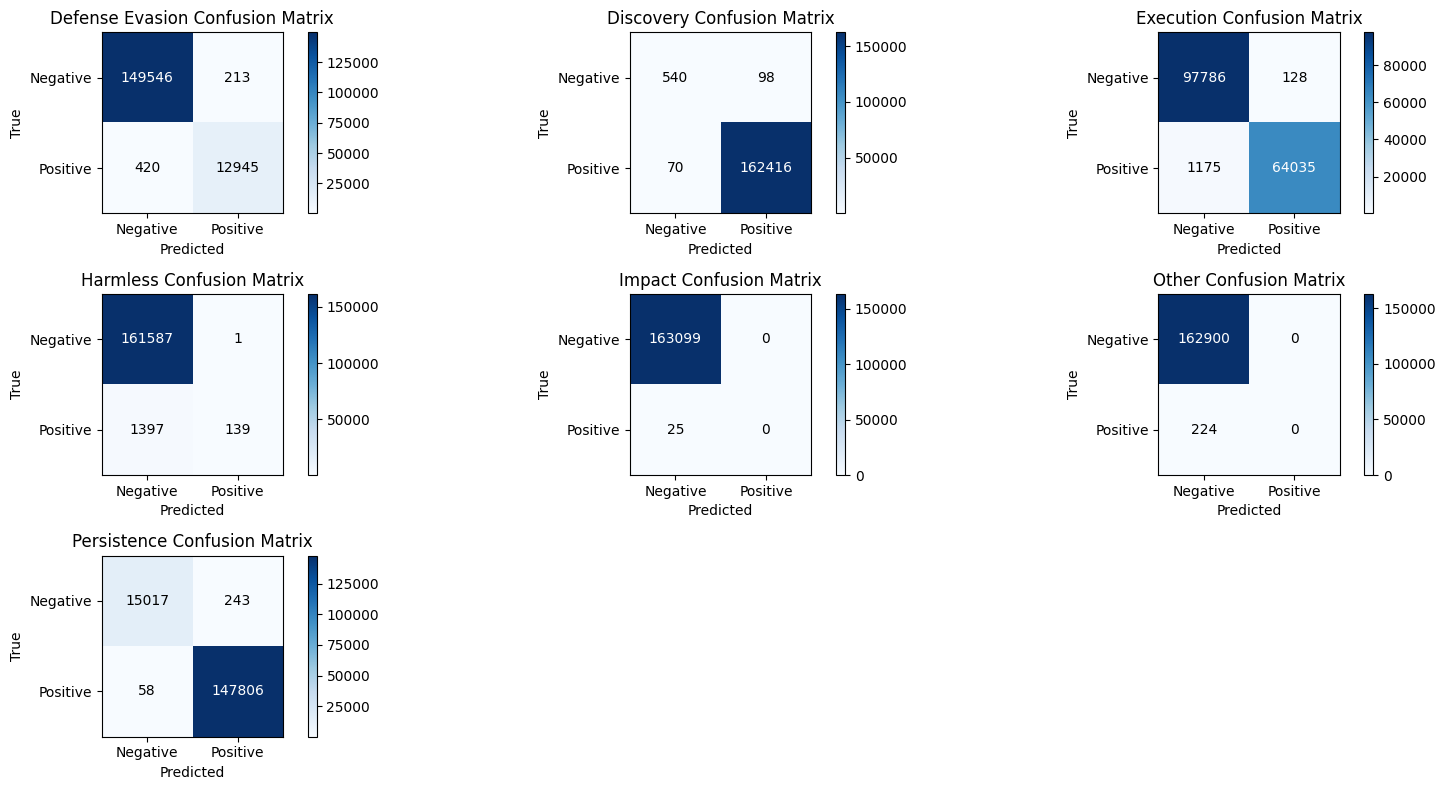


Test set Confusion Matrices:



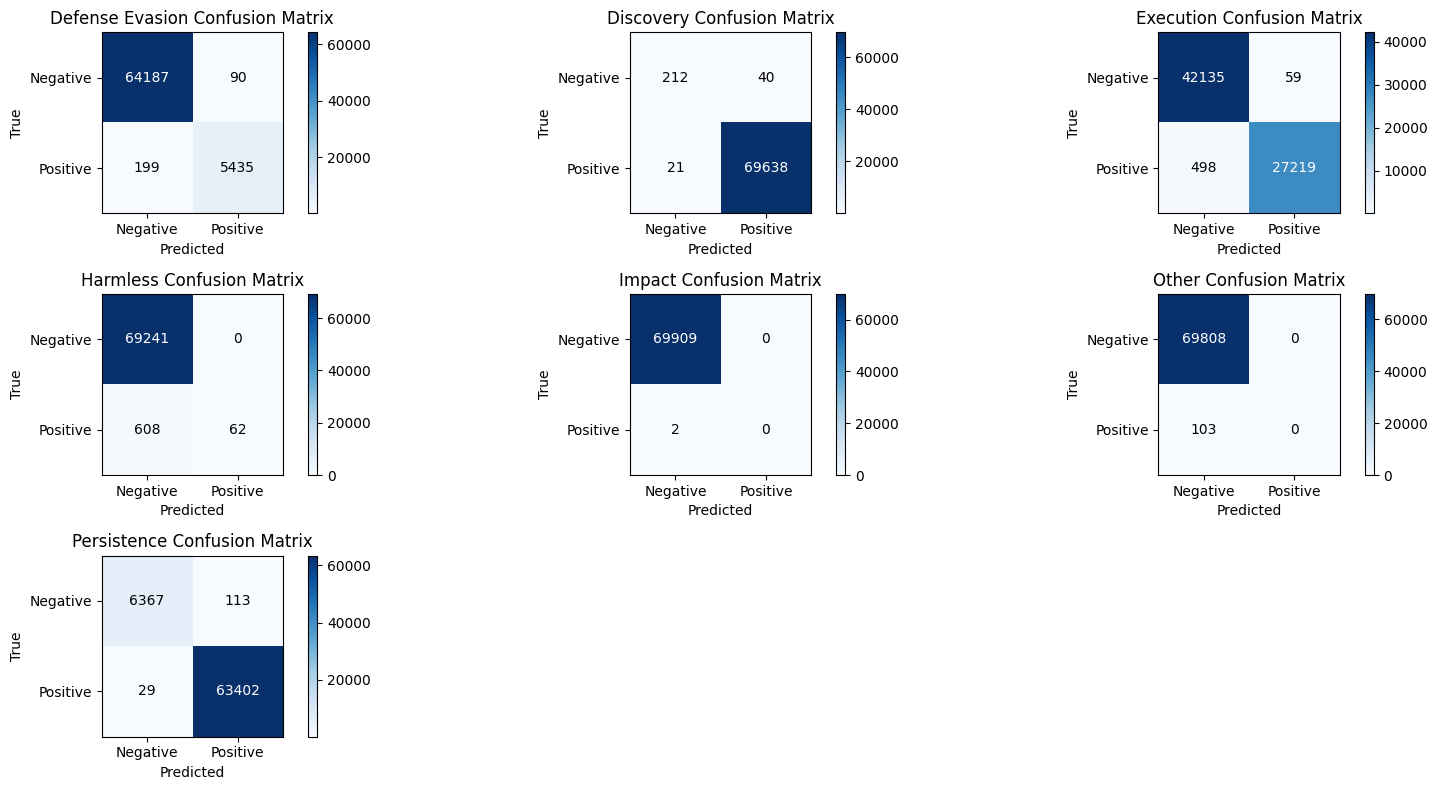

In [67]:
# classification report
print('Training set')
print(classification_report(y_train_bin, y_train_pred_lr, target_names=label_names, zero_division=1))
print('Test set')
print(classification_report(y_test_bin, y_test_pred_lr, target_names=label_names, zero_division=1))

# confusion matrices
confusion_train_lr = multilabel_confusion_matrix(y_train_bin, y_train_pred_lr)
print_confusion_matrix(confusion_train_lr, label_names, True)
confusion_test_lr = multilabel_confusion_matrix(y_test_bin, y_test_pred_lr)
print_confusion_matrix(confusion_test_lr, label_names, False)


### 2.2.2 K-Nearest Neighbors

In [64]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train_bin)
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

Training set
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98     13365
      Discovery       1.00      1.00      1.00    162486
      Execution       1.00      0.99      0.99     65210
       Harmless       0.90      0.18      0.30      1536
         Impact       0.92      0.44      0.59        25
          Other       1.00      0.97      0.99       224
    Persistence       1.00      1.00      1.00    147864

      micro avg       1.00      0.99      1.00    390710
      macro avg       0.97      0.79      0.84    390710
   weighted avg       1.00      0.99      1.00    390710
    samples avg       1.00      0.99      1.00    390710

Test set
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.99      0.99     27717
       Harmless       0.89      0.15      0.26       670
     

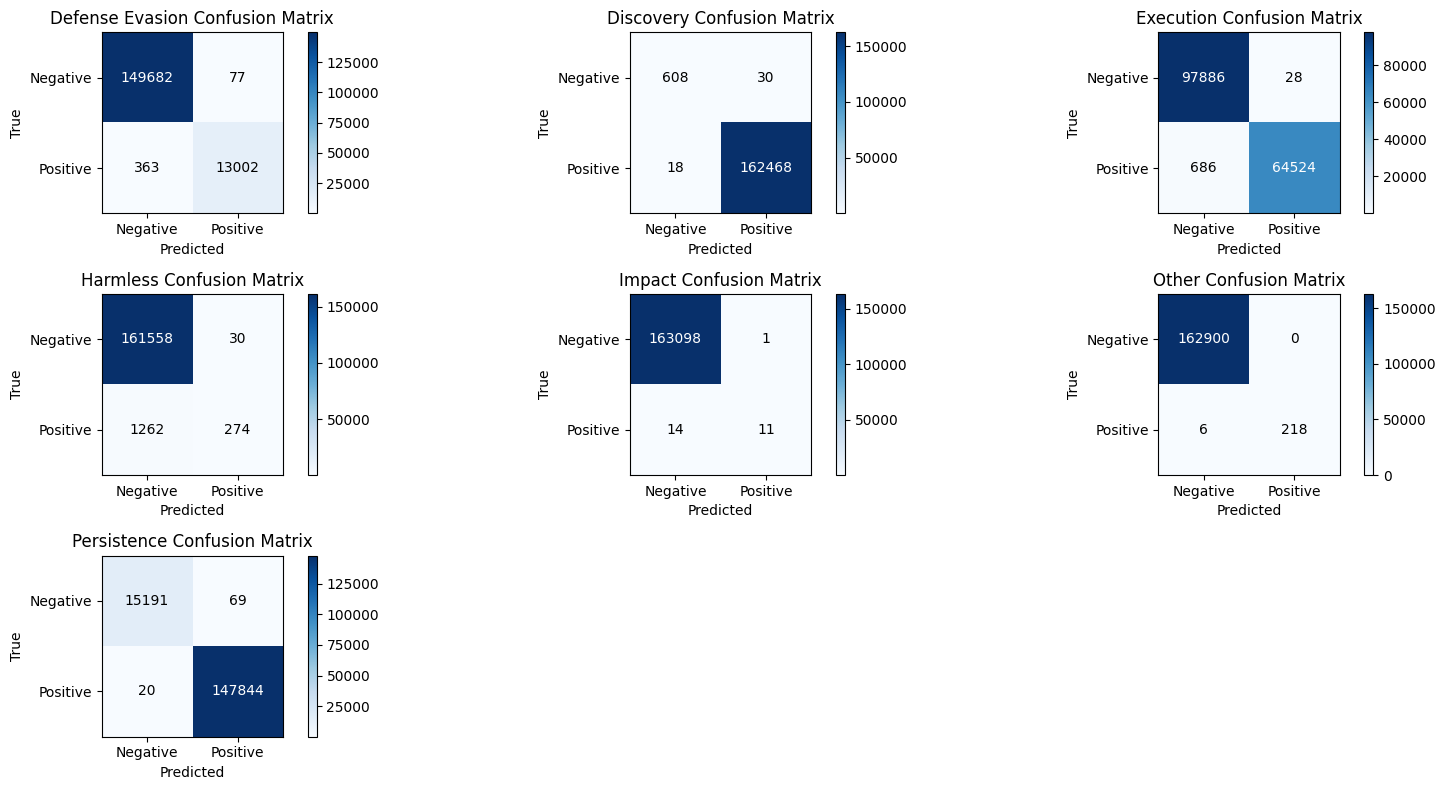


Test set Confusion Matrices:



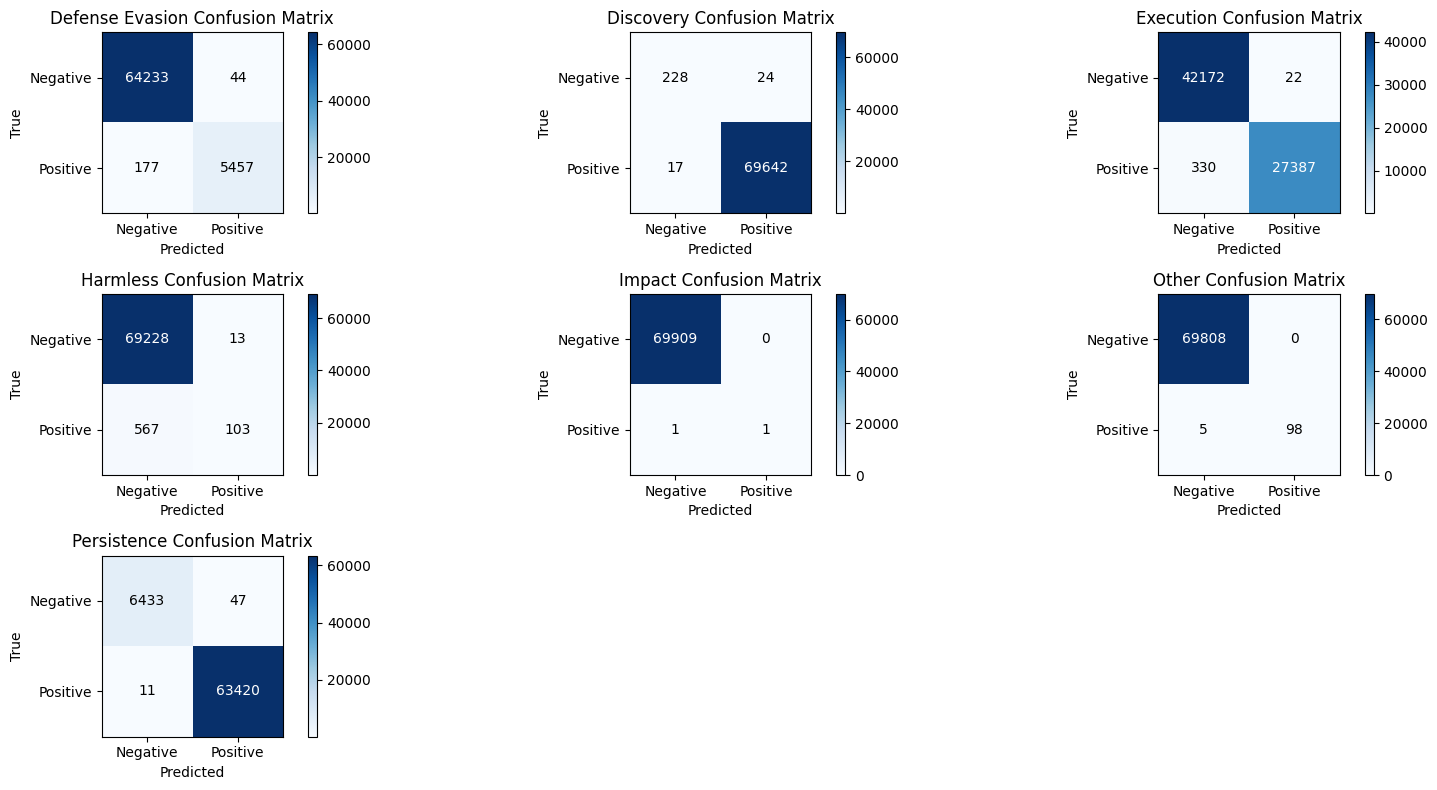

In [68]:
# classification report
print('Training set')
print(classification_report(y_train_bin, y_train_pred_knn, target_names=label_names, zero_division=1))
print('Test set')
print(classification_report(y_test_bin, y_test_pred_knn, target_names=label_names, zero_division=1))

# confusion matrices
confusion_train_knn = multilabel_confusion_matrix(y_train_bin, y_train_pred_knn)
print_confusion_matrix(confusion_train_knn, label_names, True)
confusion_test_knn = multilabel_confusion_matrix(y_test_bin, y_test_pred_knn)
print_confusion_matrix(confusion_test_knn, label_names, False)

### 2.2.3 Random Forest

In [70]:
rf_clf = RandomForestClassifier(n_estimators=30)
rf_clf.fit(X_train, y_train_bin)
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

Training set
                 precision    recall  f1-score   support

Defense Evasion       1.00      0.97      0.98     13365
      Discovery       1.00      1.00      1.00    162486
      Execution       1.00      0.99      0.99     65210
       Harmless       0.92      0.19      0.31      1536
         Impact       0.96      0.92      0.94        25
          Other       1.00      0.99      1.00       224
    Persistence       1.00      1.00      1.00    147864

      micro avg       1.00      0.99      1.00    390710
      macro avg       0.98      0.87      0.89    390710
   weighted avg       1.00      0.99      1.00    390710
    samples avg       1.00      0.99      1.00    390710

Test set
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.99      0.99     27717
       Harmless       0.90      0.16      0.27       670
     

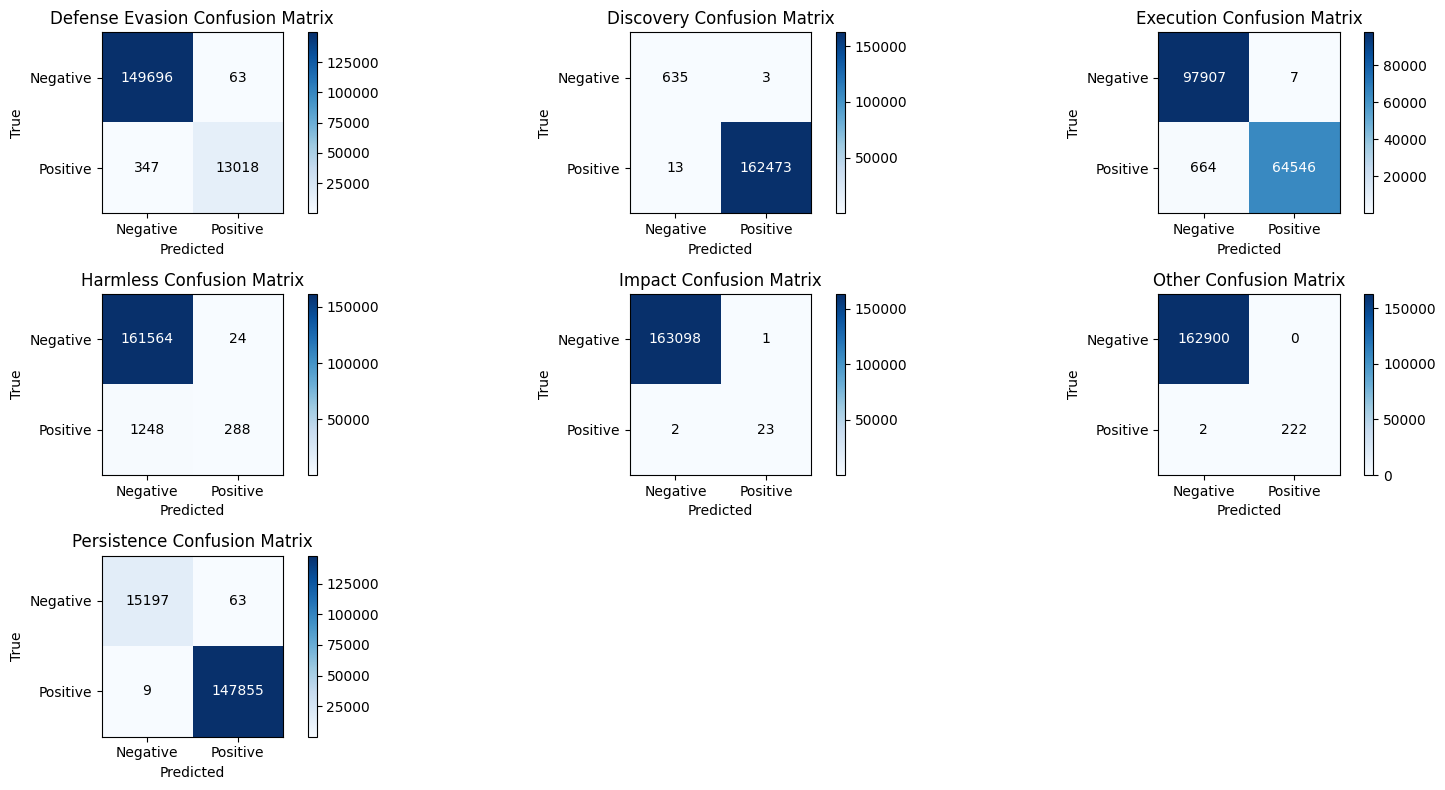


Test set Confusion Matrices:



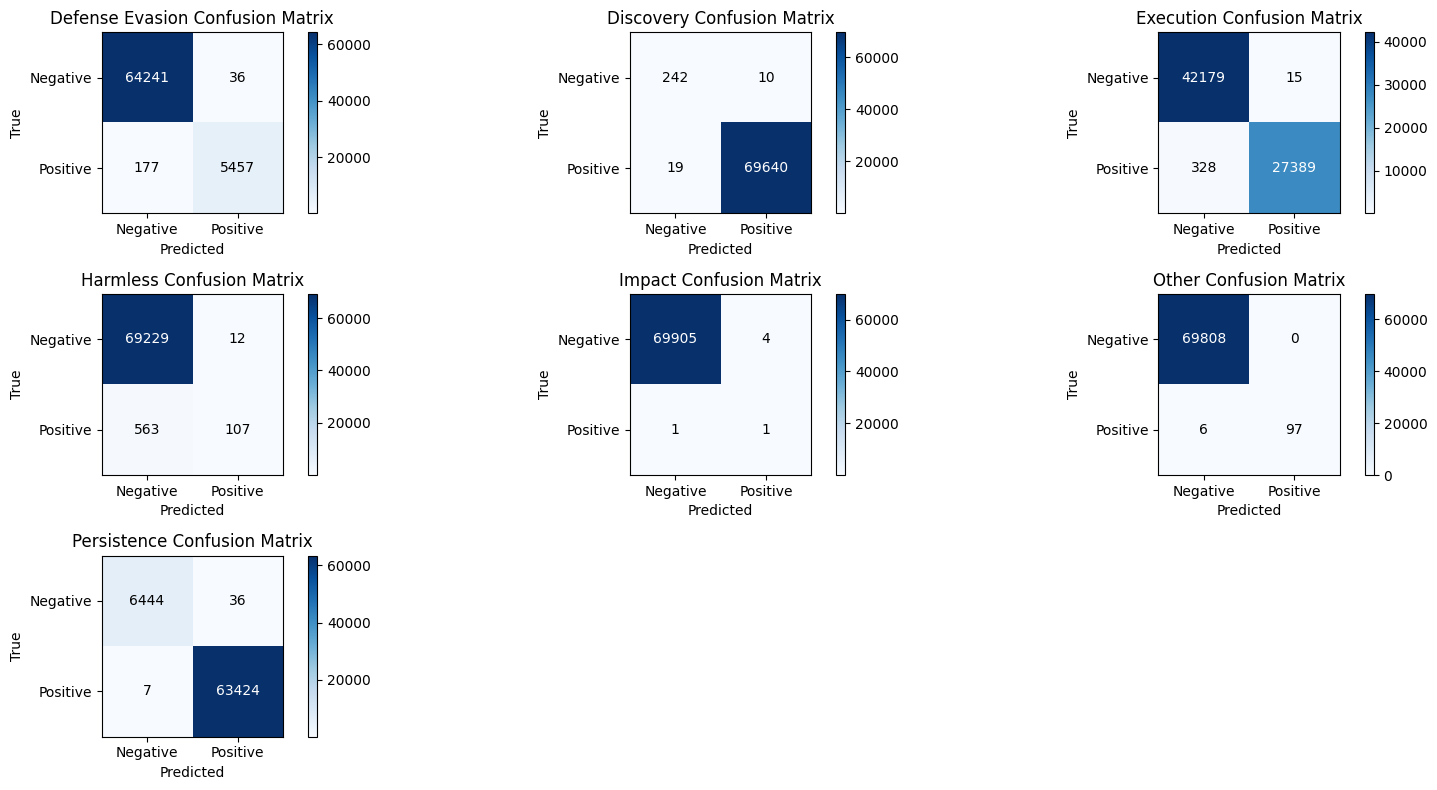

In [71]:
# classification report
print('Training set')
print(classification_report(y_train_bin, y_train_pred_rf, target_names=label_names, zero_division=1))
print('Test set')
print(classification_report(y_test_bin, y_test_pred_rf, target_names=label_names, zero_division=1))

# confusion matrices
confusion_train_rf = multilabel_confusion_matrix(y_train_bin, y_train_pred_rf)
print_confusion_matrix(confusion_train_rf, label_names, True)
confusion_test_rf = multilabel_confusion_matrix(y_test_bin, y_test_pred_rf)
print_confusion_matrix(confusion_test_rf, label_names, False)

## 2.3 Tune Hyperparameters

GridSearchCV: search for the best hyperparameter combination based on a scoring metric.

### 2.3.1 Logistic Regression

When working with MultiOutputClassifier in scikit-learn, you can perform hyperparameter tuning on the underlying estimator (e.g., Logistic Regression) by specifying the parameters of the base estimator in the parameter grid. To achieve this, you'll need to prefix the parameters with the name used to reference the base estimator in the MultiOutputClassifier object, i.e. estimator__{param}

In [96]:
# Specify the hyperparameters to tune
param_grid = {
    "estimator__C": [0.1, 1, 10],       # Regularization strength
    "estimator__solver": ["lbfgs", "liblinear", "newton-cg", "sag", "saga"],  # Solver types
    'estimator__max_iter'  : [50,100,250]
}

# Define the scoring function
scorer = make_scorer(f1_score, average="weighted", zero_division=1)

# Set up GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    verbose=True,
    n_jobs=-1
)

# Perform the search
grid_search_lr.fit(X_train, y_train_bin)

# Best parameters and score
print("Best Parameters Combination:", grid_search_lr.best_params_)
print("Best Score:", grid_search_lr.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Best Parameters Combination: {'estimator__C': 10, 'estimator__max_iter': 50, 'estimator__solver': 'saga'}
Best Score: 0.9945209518716698


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [97]:
df_grid_search_lr = pd.DataFrame(grid_search_lr.cv_results_)
df_grid_search_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__max_iter,param_estimator__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.704499,0.084267,0.098859,0.007644,0.1,50,lbfgs,"{'estimator__C': 0.1, 'estimator__max_iter': 5...",0.989909,0.989485,0.989633,0.989948,0.990107,0.989816,0.000225,34
1,7.562221,0.660832,0.234752,0.066801,0.1,50,liblinear,"{'estimator__C': 0.1, 'estimator__max_iter': 5...",0.989890,0.989491,0.989641,0.989942,0.990199,0.989833,0.000246,31
2,7.626535,1.063870,0.150605,0.040269,0.1,50,newton-cg,"{'estimator__C': 0.1, 'estimator__max_iter': 5...",0.989850,0.989491,0.989614,0.989916,0.990100,0.989794,0.000217,43
3,13.353882,0.798179,0.077366,0.013384,0.1,50,sag,"{'estimator__C': 0.1, 'estimator__max_iter': 5...",0.989884,0.989491,0.989639,0.989935,0.990107,0.989811,0.000219,37
4,15.188580,0.928475,0.085312,0.011201,0.1,50,saga,"{'estimator__C': 0.1, 'estimator__max_iter': 5...",0.989884,0.989491,0.989639,0.989935,0.990107,0.989811,0.000219,37
5,1.405901,0.078663,0.065441,0.004427,0.1,100,lbfgs,"{'estimator__C': 0.1, 'estimator__max_iter': 1...",0.989909,0.989485,0.989633,0.989948,0.990107,0.989816,0.000225,34
6,4.650713,0.275178,0.097236,0.028019,0.1,100,liblinear,"{'estimator__C': 0.1, 'estimator__max_iter': 1...",0.989890,0.989491,0.989641,0.989942,0.990199,0.989833,0.000246,31
7,4.616548,0.148358,0.099051,0.034016,0.1,100,newton-cg,"{'estimator__C': 0.1, 'estimator__max_iter': 1...",0.989850,0.989491,0.989614,0.989916,0.990100,0.989794,0.000217,43
8,11.811003,0.642594,0.078584,0.016066,0.1,100,sag,"{'estimator__C': 0.1, 'estimator__max_iter': 1...",0.989884,0.989491,0.989639,0.989935,0.990107,0.989811,0.000219,37
9,15.079166,1.290357,0.094733,0.015022,0.1,100,saga,"{'estimator__C': 0.1, 'estimator__max_iter': 1...",0.989884,0.989491,0.989639,0.989935,0.990107,0.989811,0.000219,37


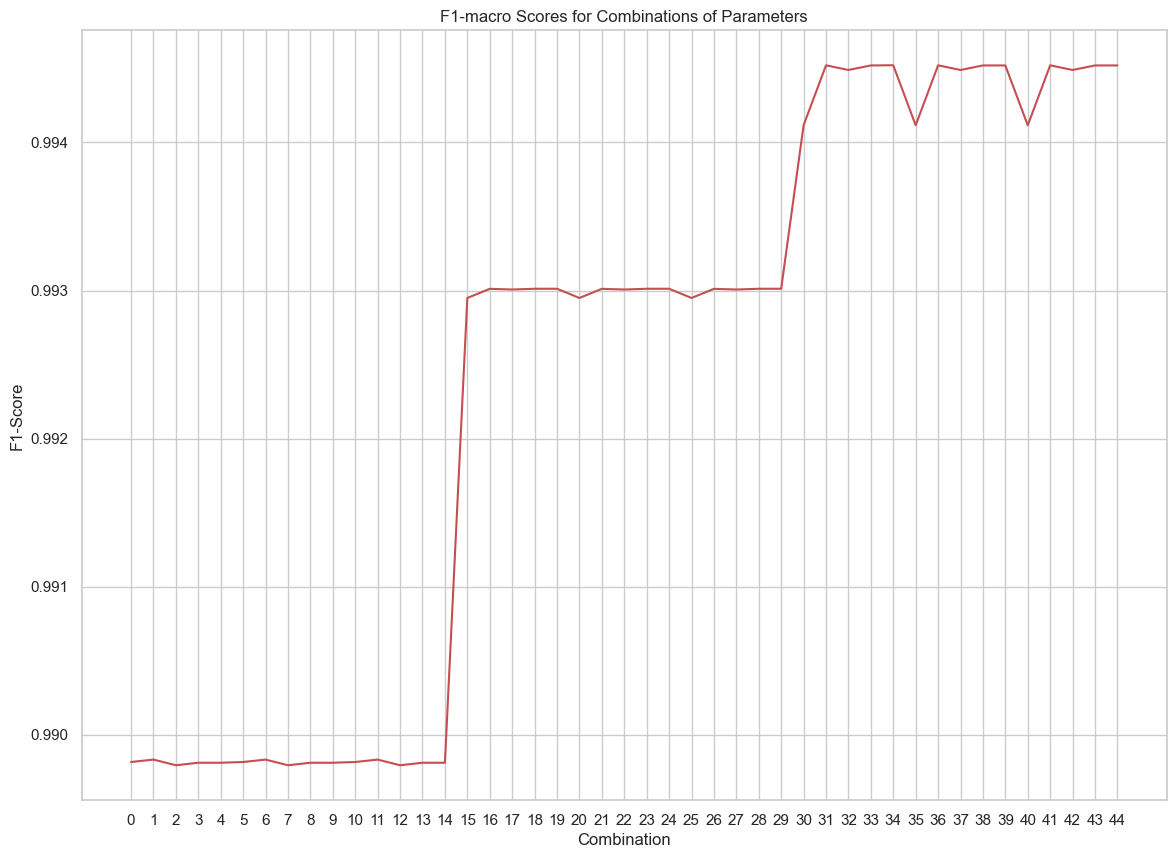

In [121]:

df_grid_search_lr = pd.DataFrame(grid_search_lr.cv_results_)
sns.lineplot(x = df_grid_search_lr.index, y = "mean_test_score", data = df_grid_search_lr, color='r')

# Set the figure size
plt.gcf().set_size_inches(14, 10)
# Add a title and labels to the plot
plt.title('F1-macro Scores for Combinations of Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-Score')

# Rotate x-axis labels by 45 degrees
plt.xticks(ticks=df_grid_search_lr.index) 

# Display the plot
plt.show()

In [126]:
pivot_data = df_grid_search_lr[['param_estimator__C', 'param_estimator__solver', 'param_estimator__max_iter', 'mean_test_score']]

# Create a pivot table
pivot_table = pivot_data.pivot_table(index=['param_estimator__C', 'param_estimator__solver', 'param_estimator__max_iter'], 
                                     values='mean_test_score')

print("\nBest parameters mean test scores:")
print(pivot_table)
pivot_table



Best parameters mean test scores:
                                                                      mean_test_score
param_estimator__C param_estimator__solver param_estimator__max_iter                 
0.1                lbfgs                   50                                0.989816
                                           100                               0.989816
                                           250                               0.989816
                   liblinear               50                                0.989833
                                           100                               0.989833
                                           250                               0.989833
                   newton-cg               50                                0.989794
                                           100                               0.989794
                                           250                               0.989794
                   

mean_test_score
param_estimator__C param_estimator__solver param_estimator__max_iter                 
0.1                lbfgs                   50                                0.989816
                                           100                               0.989816
                                           250                               0.989816
                   liblinear               50                                0.989833
                                           100                               0.989833
                                           250                               0.989833
                   newton-cg               50                                0.989794
                                           100                               0.989794
                                           250                               0.989794
                   sag                     50                                0.989811
                                           100                               0.989811
                                           250                               0.989811
                   saga                    50                                0.989811
                                           100                               0.989811
                                           250                               0.989811
1.0                lbfgs                   50                                0.992950
                                           100                               0.992950
                                           250                               0.992950
                   liblinear               50                                0.993011
                                           100                               0.993011
                                           250                               0.993011
                   newton-cg               50                                0.993007
                                           100                               0.993007
                                           250                               0.993007
                   sag                     50                                0.993012
                                           100                               0.993012
                                           250                               0.993012
                   saga                    50                                0.993012
                                           100                               0.993012
                                           250                               0.993012
10.0               lbfgs                   50                                0.994116
                                           100                               0.994116
                                           250                               0.994116
                   liblinear               50                                0.994520
                                           100                               0.994520
                                           250                               0.994520
                   newton-cg               50                                0.994489
                                           100                               0.994489
                                           250                               0.994489
                   sag                     50                                0.994520
                                           100                               0.994520
                                           250                               0.994520
                   saga                    50                                0.994521
                                           100                               0.994520
                                           250                               0.994520

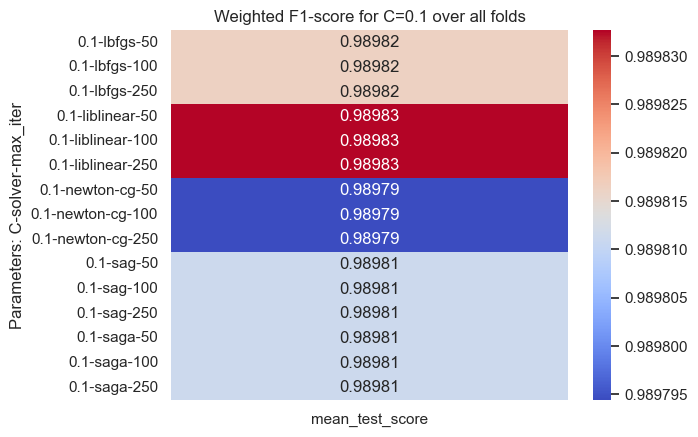

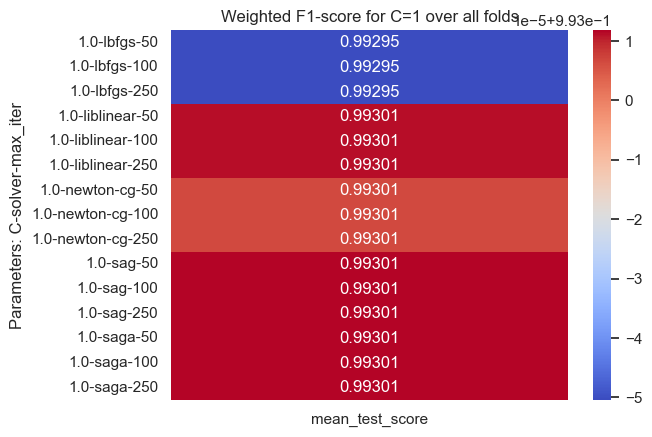

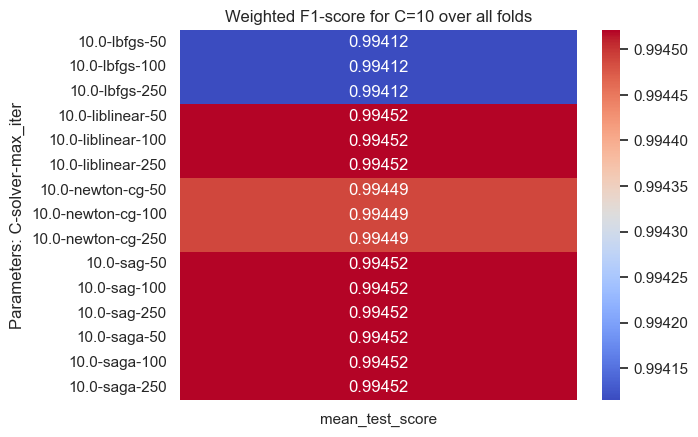

In [181]:

filtered_table_1 = pivot_table[pivot_table.index.get_level_values('param_estimator__C') == 0.1]
filtered_table_2 = pivot_table[pivot_table.index.get_level_values('param_estimator__C') == 1]
filtered_table_3 = pivot_table[pivot_table.index.get_level_values('param_estimator__C') == 10]

sns.heatmap(filtered_table_1, annot=True, cmap='coolwarm', fmt='.5g')
plt.ylabel('Parameters: C-solver-max_iter')
plt.title('Weighted F1-score for C=0.1 over all folds')
plt.show()
sns.heatmap(filtered_table_2, annot=True, cmap='coolwarm', fmt='.5g')
plt.ylabel('Parameters: C-solver-max_iter')
plt.title('Weighted F1-score for C=1 over all folds')
plt.show()
sns.heatmap(filtered_table_3, annot=True, cmap='coolwarm', fmt='.5g')
plt.ylabel('Parameters: C-solver-max_iter')
plt.title('Weighted F1-score for C=10 over all folds')
plt.show()

### 2.3.2 K-Nearest Neighbors

n_neighbors: Decide the best k based on the values we have computed earlier.

weights: Check whether adding weights to the data points is beneficial to the model or not. 'uniform' assigns no weight, while 'distance' weighs points by the inverse of their distances meaning nearer points will have more weight than the farther points.

metric: The distance metric to be used will calculating the similarity.

In [196]:
# Specify the hyperparameters to tune
param_grid = { 'n_neighbors' : [3,7,9],
               'metric' : ['minkowski','euclidean', 'manhattan', 'chebyshev']}

# Define the scoring function
scorer = make_scorer(f1_score, average="weighted", zero_division=1)

# Set up GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=True,
    n_jobs=-1
)

# Perform the search
grid_search_knn.fit(X_train, y_train_bin)

# Best parameters and score
print("Best Parameters Combination:", grid_search_knn.best_params_)
print("Best Score:", grid_search_knn.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters Combination: {'metric': 'manhattan', 'n_neighbors': 3}
Best Score: 0.9953623897044878


In [197]:
df_grid_search_knn = pd.DataFrame(grid_search_knn.cv_results_)
df_grid_search_knn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.724188,0.018020,66.815124,1.590508,minkowski,3,"{'metric': 'minkowski', 'n_neighbors': 3}",0.995304,0.995076,0.995293,0.995766,0.995162,0.995320,0.000238,2
1,0.524655,0.225866,69.729891,7.100550,minkowski,7,"{'metric': 'minkowski', 'n_neighbors': 7}",0.995169,0.994864,0.995234,0.995595,0.995117,0.995196,0.000236,6
2,0.179419,0.031797,66.549524,1.243081,minkowski,9,"{'metric': 'minkowski', 'n_neighbors': 9}",0.995119,0.994758,0.995156,0.995583,0.995031,0.995129,0.000266,9
3,0.152841,0.015859,66.586499,6.470559,euclidean,3,"{'metric': 'euclidean', 'n_neighbors': 3}",0.995304,0.995076,0.995293,0.995766,0.995162,0.995320,0.000238,2
4,0.148797,0.015897,68.765961,5.868141,euclidean,7,"{'metric': 'euclidean', 'n_neighbors': 7}",0.995169,0.994864,0.995234,0.995595,0.995117,0.995196,0.000236,6
5,0.160904,0.019645,65.446117,1.047855,euclidean,9,"{'metric': 'euclidean', 'n_neighbors': 9}",0.995119,0.994758,0.995156,0.995583,0.995031,0.995129,0.000266,9
6,0.148912,0.008239,218.820746,4.321490,manhattan,3,"{'metric': 'manhattan', 'n_neighbors': 3}",0.995348,0.995182,0.995273,0.995788,0.995219,0.995362,0.000220,1
7,0.142507,0.010198,219.474045,2.908264,manhattan,7,"{'metric': 'manhattan', 'n_neighbors': 7}",0.995207,0.995004,0.995272,0.995633,0.995174,0.995258,0.000208,4
8,0.154494,0.009939,214.070794,2.675445,manhattan,9,"{'metric': 'manhattan', 'n_neighbors': 9}",0.995187,0.994946,0.995201,0.995635,0.995104,0.995215,0.000229,5
9,0.149003,0.014408,183.353448,15.181578,chebyshev,3,"{'metric': 'chebyshev', 'n_neighbors': 3}",0.995187,0.994862,0.995115,0.995512,0.994990,0.995133,0.000220,8


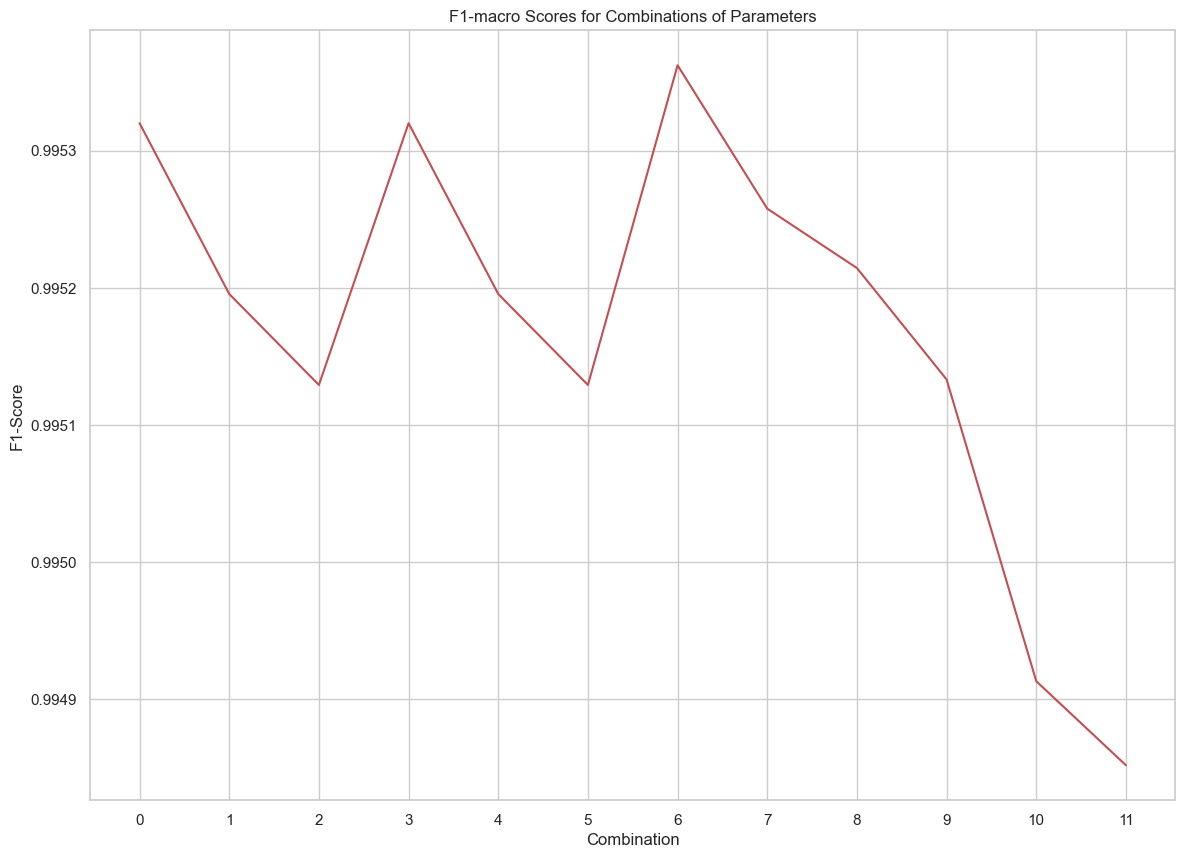

In [198]:
df_grid_search_knn = pd.DataFrame(grid_search_knn.cv_results_)
sns.lineplot(x = df_grid_search_knn.index, y = "mean_test_score", data = df_grid_search_knn, color='r')

# Set the figure size
plt.gcf().set_size_inches(14, 10)
# Add a title and labels to the plot
plt.title('F1-macro Scores for Combinations of Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-Score')

# Rotate x-axis labels by 45 degrees
plt.xticks(ticks=df_grid_search_knn.index) 

# Display the plot
plt.show()

In [207]:
pivot_data_knn = df_grid_search_knn[['param_n_neighbors', 'param_metric', 'mean_test_score']]

# Create a pivot table
pivot_table_knn = pivot_data_knn.pivot(index='param_n_neighbors', columns='param_metric', 
                                     values='mean_test_score')

print("\nBest parameters mean test scores:")
print(pivot_table_knn)
pivot_table_knn


Best parameters mean test scores:
param_metric       chebyshev  euclidean  manhattan  minkowski
param_n_neighbors                                            
3                   0.995133   0.995320   0.995362   0.995320
7                   0.994913   0.995196   0.995258   0.995196
9                   0.994852   0.995129   0.995215   0.995129


param_metric,chebyshev,euclidean,manhattan,minkowski
param_n_neighbors,,,,
3,0.995133,0.995320,0.995362,0.995320
7,0.994913,0.995196,0.995258,0.995196
9,0.994852,0.995129,0.995215,0.995129


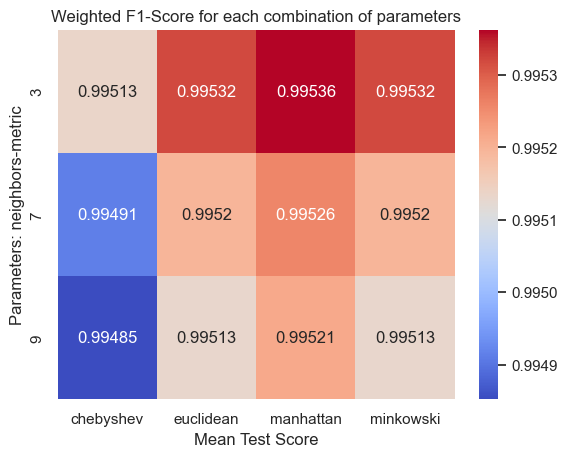

In [208]:
sns.heatmap(pivot_table_knn, annot=True, cmap='coolwarm', fmt='.5g')
plt.xlabel('Mean Test Score')
plt.ylabel('Parameters: neighbors-metric')
plt.title('Weighted F1-Score for each combination of parameters')
plt.show()

### 2.3.3 Random Forest

In [167]:
# Specify the hyperparameters to tune
param_grid = { 'n_estimators': [25, 50, 100, 150], 
              'max_depth': [3, 6, 9],
              'max_leaf_nodes': [3, 6, 9], }

# Define the scoring function
scorer = make_scorer(f1_score, average="weighted", zero_division=1)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    verbose=True,
    n_jobs=-1
)

# Perform the search
grid_search_rf.fit(X_train, y_train_bin)

# Best parameters and score
print("Best Parameters Combination:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters Combination: {'max_depth': 6, 'max_leaf_nodes': 9, 'n_estimators': 25}
Best Score: 0.9928166204605986


In [168]:
df_grid_search_rf = pd.DataFrame(grid_search_rf.cv_results_)
df_grid_search_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.646237,0.060586,0.231647,0.015949,3,3,25,"{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estim...",0.987458,0.986967,0.987051,0.987251,0.987450,0.987235,0.000201,36
1,7.689949,0.508557,0.355359,0.048944,3,3,50,"{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estim...",0.987144,0.986950,0.986998,0.987425,0.987763,0.987256,0.000303,35
2,15.127574,0.136184,0.537370,0.033599,3,3,100,"{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estim...",0.987590,0.986934,0.987230,0.987424,0.987719,0.987379,0.000277,31
3,23.856682,0.355583,0.913393,0.097232,3,3,150,"{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estim...",0.987589,0.986953,0.987245,0.987405,0.987750,0.987389,0.000276,30
4,4.433603,0.258039,0.242331,0.030329,3,6,25,"{'max_depth': 3, 'max_leaf_nodes': 6, 'n_estim...",0.991459,0.991183,0.991181,0.991723,0.991465,0.991402,0.000203,22
5,8.649312,0.127042,0.358452,0.031586,3,6,50,"{'max_depth': 3, 'max_leaf_nodes': 6, 'n_estim...",0.991657,0.991040,0.991464,0.991525,0.991238,0.991385,0.000219,24
6,17.095719,0.251292,0.583165,0.044202,3,6,100,"{'max_depth': 3, 'max_leaf_nodes': 6, 'n_estim...",0.991638,0.991270,0.991184,0.991735,0.991499,0.991465,0.000210,21
7,24.178532,0.559985,0.995900,0.238872,3,6,150,"{'max_depth': 3, 'max_leaf_nodes': 6, 'n_estim...",0.991696,0.991020,0.991184,0.991735,0.991328,0.991393,0.000281,23
8,3.901711,0.087709,0.198696,0.006260,3,9,25,"{'max_depth': 3, 'max_leaf_nodes': 9, 'n_estim...",0.992400,0.991806,0.991142,0.992614,0.992147,0.992022,0.000516,11
9,9.105390,0.687870,0.403832,0.092166,3,9,50,"{'max_depth': 3, 'max_leaf_nodes': 9, 'n_estim...",0.991739,0.992145,0.991613,0.991934,0.991854,0.991857,0.000180,14


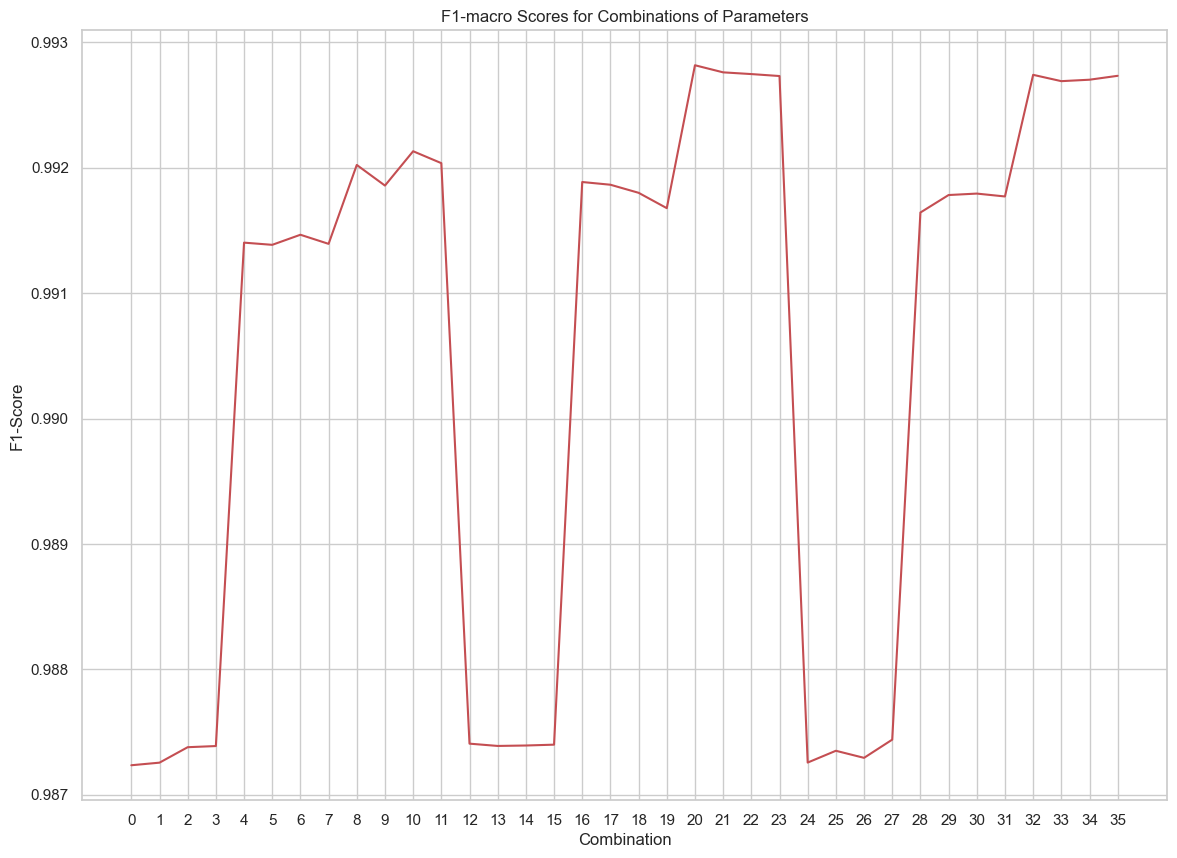

In [169]:
df_grid_search_rf = pd.DataFrame(grid_search_rf.cv_results_)
sns.lineplot(x = df_grid_search_rf.index, y = "mean_test_score", data = df_grid_search_rf, color='r')

# Set the figure size
plt.gcf().set_size_inches(14, 10)
# Add a title and labels to the plot
plt.title('F1-macro Scores for Combinations of Parameters')
plt.xlabel('Combination')
plt.ylabel('F1-Score')

# Rotate x-axis labels by 45 degrees
plt.xticks(ticks=df_grid_search_rf.index) 

# Display the plot
plt.show()

In [174]:
pivot_data_rf = df_grid_search_rf[['param_n_estimators', 'param_max_depth', 'param_max_leaf_nodes', 'mean_test_score']]

pivot_table_rf = pivot_data_rf.pivot_table(index=['param_n_estimators','param_max_depth', 'param_max_leaf_nodes'], values='mean_test_score')
print("\nBest parameters mean test scores:")
print(pivot_table_rf)
pivot_table_rf


Best parameters mean test scores:
                                                         mean_test_score
param_n_estimators param_max_depth param_max_leaf_nodes                 
25                 3               3                            0.987235
                                   6                            0.991402
                                   9                            0.992022
                   6               3                            0.987408
                                   6                            0.991886
                                   9                            0.992817
                   9               3                            0.987257
                                   6                            0.991642
                                   9                            0.992740
50                 3               3                            0.987256
                                   6                            0.991385
                

mean_test_score
param_n_estimators param_max_depth param_max_leaf_nodes                 
25                 3               3                            0.987235
                                   6                            0.991402
                                   9                            0.992022
                   6               3                            0.987408
                                   6                            0.991886
                                   9                            0.992817
                   9               3                            0.987257
                                   6                            0.991642
                                   9                            0.992740
50                 3               3                            0.987256
                                   6                            0.991385
                                   9                            0.991857
                   6               3                            0.987389
                                   6                            0.991864
                                   9                            0.992760
                   9               3                            0.987351
                                   6                            0.991782
                                   9                            0.992690
100                3               3                            0.987379
                                   6                            0.991465
                                   9                            0.992131
                   6               3                            0.987393
                                   6                            0.991800
                                   9                            0.992746
                   9               3                            0.987295
                                   6                            0.991793
                                   9                            0.992701
150                3               3                            0.987389
                                   6                            0.991393
                                   9                            0.992036
                   6               3                            0.987400
                                   6                            0.991677
                                   9                            0.992731
                   9               3                            0.987440
                                   6                            0.991770
                                   9                            0.992732

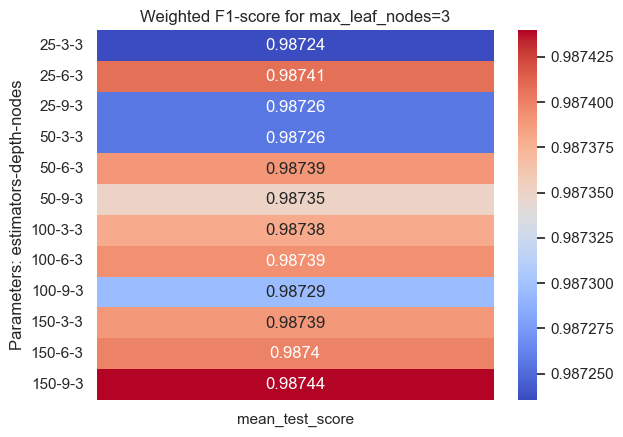

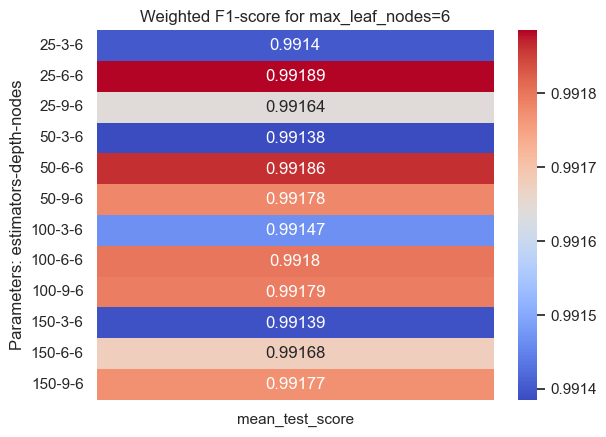

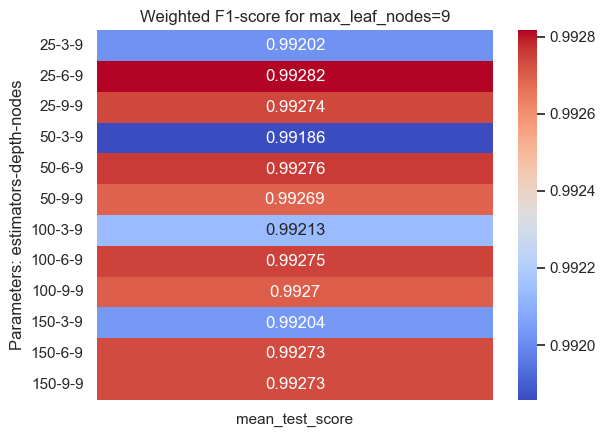

In [180]:
filtered_table_rf_1 = pivot_table_rf[pivot_table_rf.index.get_level_values('param_max_leaf_nodes') == 3]
filtered_table_rf_2 = pivot_table_rf[pivot_table_rf.index.get_level_values('param_max_leaf_nodes') == 6]
filtered_table_rf_3 = pivot_table_rf[pivot_table_rf.index.get_level_values('param_max_leaf_nodes') == 9]

sns.heatmap(filtered_table_rf_1, annot=True, cmap='coolwarm', fmt='.5g')
plt.ylabel('Parameters: estimators-depth-nodes')
plt.title('Weighted F1-score for max_leaf_nodes=3')
plt.show()
sns.heatmap(filtered_table_rf_2, annot=True, cmap='coolwarm', fmt='.5g')
plt.ylabel('Parameters: estimators-depth-nodes')
plt.title('Weighted F1-score for max_leaf_nodes=6')
plt.show()
sns.heatmap(filtered_table_rf_3, annot=True, cmap='coolwarm', fmt='.5g')
plt.ylabel('Parameters: estimators-depth-nodes')
plt.title('Weighted F1-score for max_leaf_nodes=9')
plt.show()

## 2.4 Evaluating on each intent

### 2.4.1 Evaluation with Logistic Regression

In [190]:
# tuned model
lr_tuned = MultiOutputClassifier(LogisticRegression(C = grid_search_lr.best_params_["estimator__C"],
                                                   solver = grid_search_lr.best_params_["estimator__solver"],
                                                   max_iter = grid_search_lr.best_params_["estimator__max_iter"])).fit(X_train, y_train_bin)

y_test_pred_t = lr_tuned.predict(X_test)


accuracy = lr_tuned.score(X_test, y_test_bin)
f1_t = f1_score(y_test_bin, y_test_pred_t, average='weighted')

print(f"\nTest Set Accuracy for Logistic Regression model: {accuracy:.5f}")
print(f"F1-score for Logistic Regression model: {f1_t:.5f}",'\n')

report_test_t = classification_report(y_test_bin, y_test_pred_t, target_names=label_names, output_dict=True, zero_division=1)
df_report_test_t = pd.DataFrame(report_test_t).transpose()
print(df_report_test_t)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma


Test Set Accuracy for Logistic Regression model: 0.98201
F1-score for Logistic Regression model: 0.99434 

                 precision    recall  f1-score   support
Defense Evasion   0.987803  0.963081  0.975285    5634.0
Discovery         0.999799  0.999684  0.999742   69659.0
Execution         0.998396  0.987805  0.993072   27717.0
Harmless          0.969697  0.095522  0.173913     670.0
Impact            1.000000  0.000000  0.000000       2.0
Other             1.000000  0.951456  0.975124     103.0
Persistence       0.999133  0.999622  0.999377   63431.0
micro avg         0.998905  0.992794  0.995840  167216.0
macro avg         0.993547  0.713882  0.730931  167216.0
weighted avg      0.998789  0.992794  0.994338  167216.0
samples avg       0.998785  0.993825  0.995471  167216.0


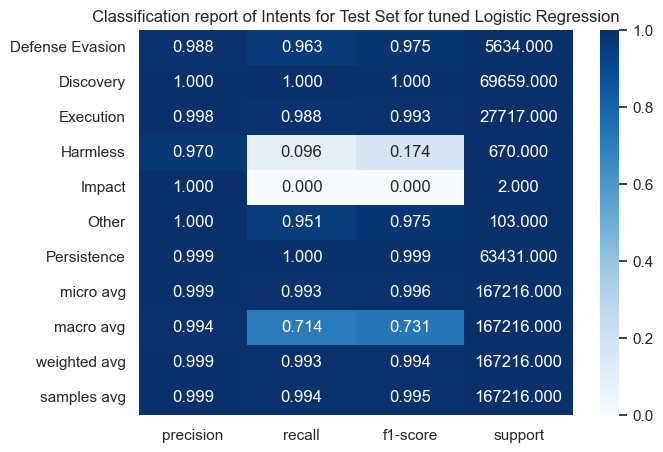

In [193]:
# correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(df_report_test_t, cmap='Blues', annot=True, vmin=.0, vmax=1, fmt='.3f')
plt.title('Classification report of Intents for Test Set for tuned Logistic Regression')
plt.show()

### 2.4.2 Evaluation with Random Forest

In [188]:
# tuned model
print(grid_search_rf.best_params_)
rf_tuned = RandomForestClassifier(n_estimators = grid_search_rf.best_params_["n_estimators"], 
                                  max_depth = grid_search_rf.best_params_["max_depth"],).fit(X_train, y_train_bin)

y_test_pred_t = rf_tuned.predict(X_test)


accuracy = rf_tuned.score(X_test, y_test_bin)
f1_t = f1_score(y_test_bin, y_test_pred_t, average='weighted')

print(f"\nTest Set Accuracy for Random Forest model: {accuracy:.5f}")
print(f"F1-score for Random Forest model: {f1_t:.5f}",'\n')

report_test_rf_t = classification_report(y_test_bin, y_test_pred_t, target_names=label_names, output_dict=True, zero_division=1)
df_report_test_rf_t = pd.DataFrame(report_test_rf_t).transpose()
print(df_report_test_rf_t)

{'max_depth': 6, 'max_leaf_nodes': 9, 'n_estimators': 25}

Test Set Accuracy for Random Forest model: 0.98351
F1-score for Random Forest model: 0.99495 

                 precision    recall  f1-score   support
Defense Evasion   0.992180  0.968406  0.980149    5634.0
Discovery         0.999914  0.999440  0.999677   69659.0
Execution         0.998069  0.988527  0.993275   27717.0
Harmless          0.945455  0.155224  0.266667     670.0
Impact            1.000000  0.000000  0.000000       2.0
Other             1.000000  0.941748  0.970000     103.0
Persistence       0.999338  0.999779  0.999559   63431.0
micro avg         0.999098  0.993284  0.996182  167216.0
macro avg         0.990708  0.721875  0.744190  167216.0
weighted avg      0.998911  0.993284  0.994946  167216.0
samples avg       0.998795  0.994027  0.995670  167216.0


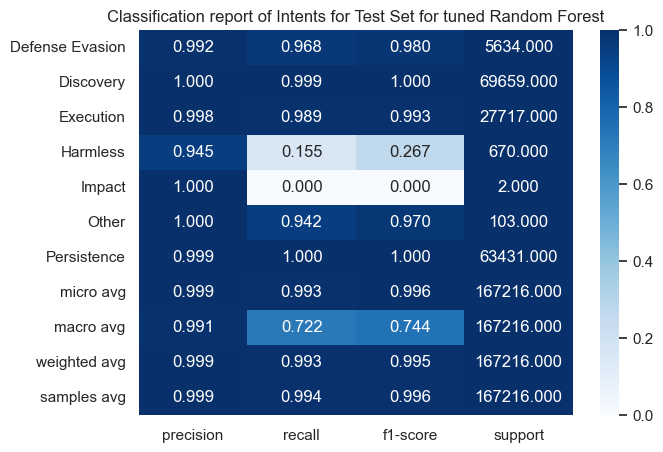

In [194]:
# correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(df_report_test_rf_t, cmap='Blues', annot=True, vmin=.0, vmax=1, fmt='.3f')
plt.title('Classification report of Intents for Test Set for tuned Random Forest')
plt.show()

### 2.4.3 Evaluation with KNN

In [209]:
# tuned model
print(grid_search_knn.best_params_)
knn_tuned = KNeighborsClassifier(n_neighbors = grid_search_knn.best_params_["n_neighbors"], 
                                  metric = grid_search_knn.best_params_["metric"],).fit(X_train, y_train_bin)

y_test_pred_t = rf_tuned.predict(X_test)


accuracy = knn_tuned.score(X_test, y_test_bin)
f1_t = f1_score(y_test_bin, y_test_pred_t, average='weighted')

print(f"\nTest Set Accuracy for KNN model: {accuracy:.5f}")
print(f"F1-score for KNN model: {f1_t:.5f}",'\n')

report_test_knn_t = classification_report(y_test_bin, y_test_pred_t, target_names=label_names, output_dict=True, zero_division=1)
df_report_test_knn_t = pd.DataFrame(report_test_knn_t).transpose()

print(df_report_test_knn_t)

{'metric': 'manhattan', 'n_neighbors': 3}

Test Set Accuracy for KNN model: 0.98377
F1-score for KNN model: 0.99495 

                 precision    recall  f1-score   support
Defense Evasion   0.992180  0.968406  0.980149    5634.0
Discovery         0.999914  0.999440  0.999677   69659.0
Execution         0.998069  0.988527  0.993275   27717.0
Harmless          0.945455  0.155224  0.266667     670.0
Impact            1.000000  0.000000  0.000000       2.0
Other             1.000000  0.941748  0.970000     103.0
Persistence       0.999338  0.999779  0.999559   63431.0
micro avg         0.999098  0.993284  0.996182  167216.0
macro avg         0.990708  0.721875  0.744190  167216.0
weighted avg      0.998911  0.993284  0.994946  167216.0
samples avg       0.998795  0.994027  0.995670  167216.0


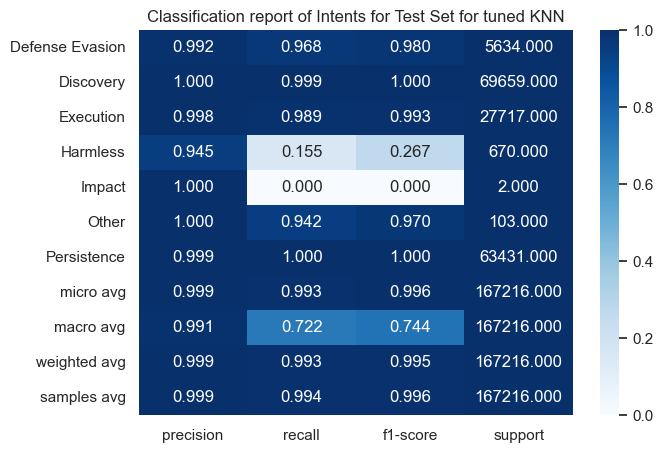

In [211]:
plt.figure(figsize=(7, 5))
sns.heatmap(df_report_test_rf_t, cmap='Blues', annot=True, vmin=.0, vmax=1, fmt='.3f')
plt.title('Classification report of Intents for Test Set for tuned KNN')
plt.show()